In [8]:
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy import special
from tqdm import tqdm
from math import floor
import statsmodels.api as sm

In [9]:
def gen():
    return int(np.random.random() * 10**6)

def generator_uniform(n):
    return np.sort(np.random.uniform(-np.sqrt(3), np.sqrt(3), n))

def generator_normal(n):
    return np.sort(np.random.normal(0, 1, n))

def generator_exponential(n):
    return np.sort(stats.expon(scale=1, loc=-1).rvs(size=n, random_state=gen()))

# 2. Достаточный размер выборки для данных с погрешностями (1% и 99% квантили)

Пусть для всех $x_i = \tilde{x_i} + \delta_i$ верно $|\delta_i| < \Delta$ = 0.5

In [10]:
Q = 0.95
DELTA = 0.5

# 3. Зависимости погрешности левой и правой границ доверительного интервала от предела погрешности

In [11]:
np.arange(0.1, 1.6, 0.1)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5])

In [32]:
def get_weighted_elements(array, index):
    index_int = floor(index)
    index_piece = index - index_int

    if index_int == array.size - 1:
        return array[index_int]

    return array[index_int] * (1 - index_piece) + array[index_int + 1] * index_piece

def get_quantile_interval(sample, p, Q=0.95):
    n = sample.size
    sample = np.sort(sample)
    quant = stats.norm.ppf((1 + Q) / 2)
    assert(n * p * (1 - p) > 0)
    k_1, k_2 = n * p - np.sqrt(n * p * (1 - p)) * quant, n * p + np.sqrt(n * p * (1 - p)) * quant

    k_1, k_2 = int(max(0, k_1)), int(min(n - 1, k_2))

    assert(k_1 < k_2)
    return [k_1, k_2]

In [29]:
def estimate_bounds_error(sample, errors, k1, k2):
    lefts, rights = sample - errors, sample + errors
    lefts, rights = np.sort(lefts), np.sort(rights) # sample is already sorted

    return max(rights[k1] - sample[k1], sample[k1] - lefts[k1]), max(rights[k2] - sample[k2], sample[k2] - lefts[k2])

In [33]:
def estimate_bounds_error_avg(generator, p, delta, n = 10**3, N=10**4):
    s_lefts, s_rights = 0, 0
    for _ in range(N):
        sample = generator(n)
        k1, k2 = get_quantile_interval(sample, p)
        errors = np.random.uniform(0, delta, n)
        k1_error, k2_error = estimate_bounds_error(sample, errors, k1, k2)

        s_lefts += k1_error
        s_rights += k2_error

    return s_lefts / N, s_rights / N

In [ ]:
n_arange = np.arange(0.1, 1.6, 0.1)

errors_uniform = [estimate_bounds_error_avg(generator_uniform, 0.01, delta) for delta in n_arange]
errors_normal = [estimate_bounds_error_avg(generator_normal, 0.01, delta) for delta in n_arange]
errors_exponential = [estimate_bounds_error_avg(generator_exponential, 0.01, delta) for delta in n_arange]

errors_uniform, errors_normal, errors_exponential = map(np.array, [errors_uniform, errors_normal, errors_exponential])

In [46]:
errors_uniform_new = [estimate_bounds_error_avg(generator_uniform, 0.99, delta) for delta in n_arange]
errors_normal_new = [estimate_bounds_error_avg(generator_normal, 0.99, delta) for delta in n_arange]
errors_exponential_new = [estimate_bounds_error_avg(generator_exponential, 0.99, delta) for delta in n_arange]

errors_uniform_new, errors_normal_new, errors_exponential_new = map(np.array, [errors_uniform_new, errors_normal_new, errors_exponential_new])

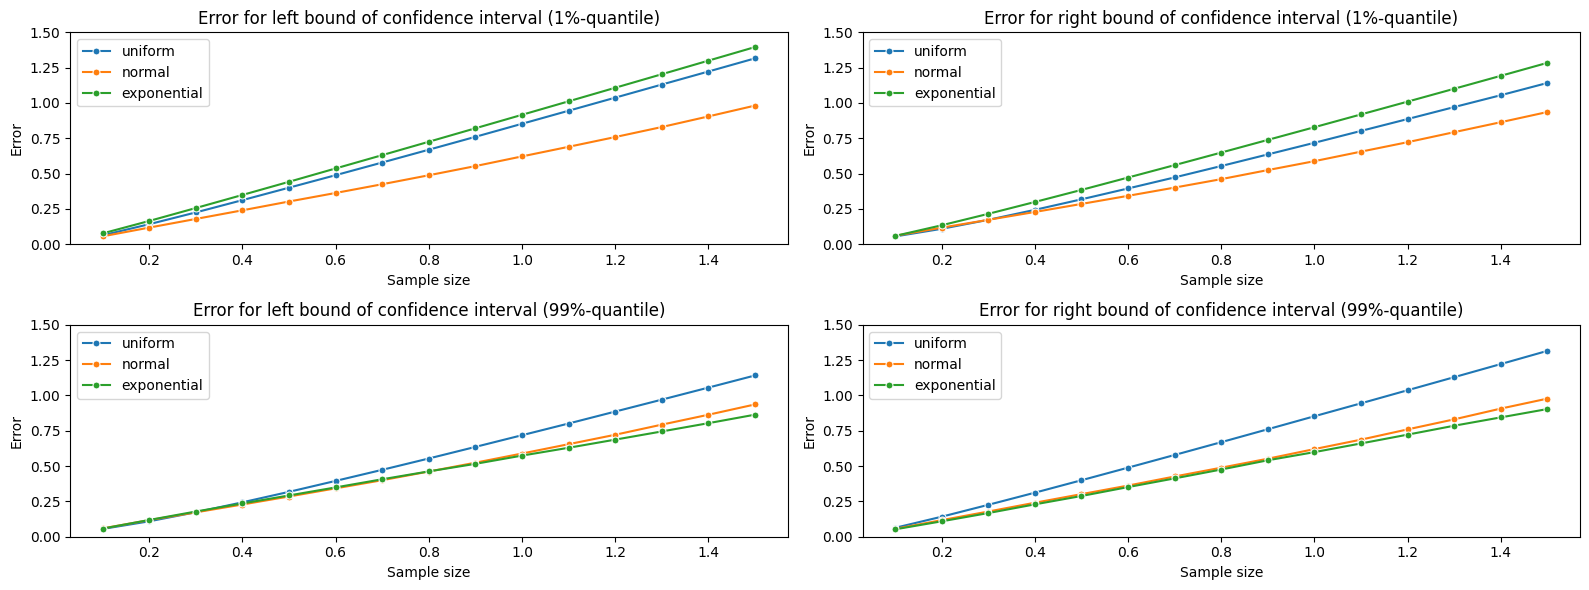

In [48]:
data_1 = pd.DataFrame({'x': n_arange, 'y': errors_uniform[:, 0]})
data_2 = pd.DataFrame({'x': n_arange, 'y': errors_normal[:, 0]})
data_3 = pd.DataFrame({'x': n_arange, 'y': errors_exponential[:, 0]})

data_4 = pd.DataFrame({'x': n_arange, 'y': errors_uniform[:, 1]})
data_5 = pd.DataFrame({'x': n_arange, 'y': errors_normal[:, 1]})
data_6 = pd.DataFrame({'x': n_arange, 'y': errors_exponential[:, 1]})

data_7 = pd.DataFrame({'x': n_arange, 'y': errors_uniform_new[:, 0]})
data_8 = pd.DataFrame({'x': n_arange, 'y': errors_normal_new[:, 0]})
data_9 = pd.DataFrame({'x': n_arange, 'y': errors_exponential_new[:, 0]})

data_10 = pd.DataFrame({'x': n_arange, 'y': errors_uniform_new[:, 1]})
data_11 = pd.DataFrame({'x': n_arange, 'y': errors_normal_new[:, 1]})
data_12 = pd.DataFrame({'x': n_arange, 'y': errors_exponential_new[:, 1]})

fig, axes = plt.subplots(2, 2, figsize=(16, 6))

sns.lineplot(data=data_1, x='x', y='y', marker='o', markersize=5, label='uniform', ax=axes[0][0])
sns.lineplot(data=data_2, x='x', y='y', marker='o', markersize=5, label='normal', ax=axes[0][0])
sns.lineplot(data=data_3, x='x', y='y', marker='o', markersize=5, label='exponential', ax=axes[0][0])
axes[0][0].set_title("Error for left bound of confidence interval (1%-quantile)")
axes[0][0].set_xlabel("Sample size")
axes[0][0].set_ylabel("Error")
axes[0][0].set_ylim(0, 1.5)

sns.lineplot(data=data_4, x='x', y='y', marker='o', markersize=5, label='uniform', ax=axes[0][1])
sns.lineplot(data=data_5, x='x', y='y', marker='o', markersize=5, label='normal', ax=axes[0][1])
sns.lineplot(data=data_6, x='x', y='y', marker='o', markersize=5, label='exponential', ax=axes[0][1])
axes[0][1].set_title("Error for right bound of confidence interval (1%-quantile)")
axes[0][1].set_xlabel("Sample size")
axes[0][1].set_ylabel("Error")
axes[0][1].set_ylim(0, 1.5)

sns.lineplot(data=data_7, x='x', y='y', marker='o', markersize=5, label='uniform', ax=axes[1][0])
sns.lineplot(data=data_8, x='x', y='y', marker='o', markersize=5, label='normal', ax=axes[1][0])
sns.lineplot(data=data_9, x='x', y='y', marker='o', markersize=5, label='exponential', ax=axes[1][0])
axes[1][0].set_title("Error for left bound of confidence interval (99%-quantile)")
axes[1][0].set_xlabel("Sample size")
axes[1][0].set_ylabel("Error")
axes[1][0].set_ylim(0, 1.5)

sns.lineplot(data=data_10, x='x', y='y', marker='o', markersize=5, label='uniform', ax=axes[1][1])
sns.lineplot(data=data_11, x='x', y='y', marker='o', markersize=5, label='normal', ax=axes[1][1])
sns.lineplot(data=data_12, x='x', y='y', marker='o', markersize=5, label='exponential', ax=axes[1][1])
axes[1][1].set_title("Error for right bound of confidence interval (99%-quantile)")
axes[1][1].set_xlabel("Sample size")
axes[1][1].set_ylabel("Error")
axes[1][1].set_ylim(0, 1.5)

plt.tight_layout()
plt.show();